In [1]:
import haversine as hs
from haversine import Unit
from scan_area import ScanArea
import math
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm
from shapely.ops import linemerge, unary_union, polygonize
from shapely.geometry import LineString, Polygon, Point
from matplotlib import pyplot as plt
import geopandas as gpd


In [2]:
coordinates2 =[[41.08615,29.03986],[41.08550,29.03955],[41.08490,29.04151],[41.08581,29.04182],[41.08653,29.04063]]
coordinates=[[41.085275, 29.040304], [41.085803, 29.040478], [41.085679, 29.041173], [41.085148, 29.040999], [41.085275, 29.040304]]

In [3]:
from route_division import *

result = route_planning(coordinates2,[1,2,3,4],40,0.8,0,20)

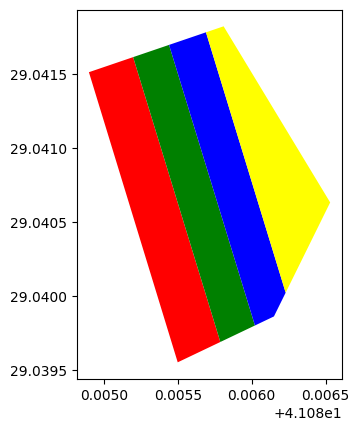

In [4]:
plot(result.polygons)



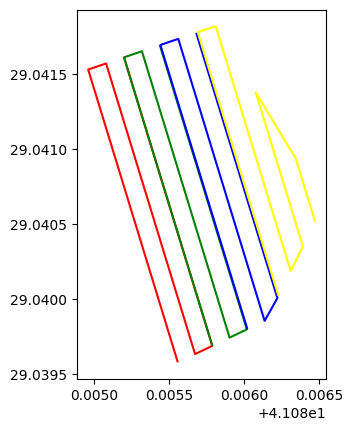

In [6]:
routes = []
for r in result.optimal_routes:
    routes.append(LineString(r))
plot(routes)


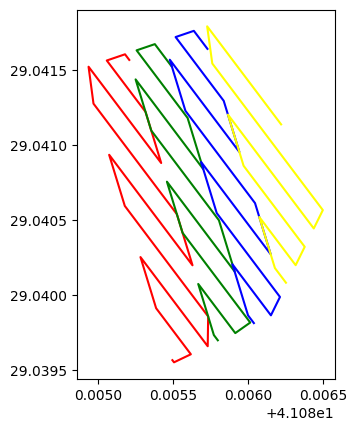

In [5]:
routes = []
for r in result.rotated_routes:
    routes.append(LineString(r))
plot(routes)


In [ ]:
nodes = []
for coord in coordinates:
    nodes.append((coord[0], coord[1]))


route_angle = (math.pi * 0 / 180)
rotated_route_angle = (math.pi * 20 / 180)
polygon = ScanArea(coords=nodes)
optimal_route_nodes, rotated_route_nodes = polygon.create_route(40, 0.8, route_angle, rotated_route_angle)
longest = polygon.find_the_longest_edge()
longest_point1 = longest.coords[0]
longest_point2 = longest.coords[1]


In [ ]:
def get_route(coordinates,altitude,rate,rotated_route_angle,route_angle):
    nodes = []
    for coord in coordinates:
        nodes.append((coord[0], coord[1]))
    route_angle_radians = (math.pi * route_angle / 180)
    rotated_route_angle_radians = (math.pi * rotated_route_angle / 180)
    polygon = ScanArea(coords=nodes)
    optimal_route_nodes, rotated_route_nodes = polygon.create_route(altitude, rate, route_angle_radians, rotated_route_angle_radians,0)

    return(optimal_route_nodes,rotated_route_nodes)

In [ ]:
def get_edges(coords):
    edges = []
    for i in range(len(coords) - 1):
        edges.append(LineString([coords[i], coords[i + 1]]))
    edges.append(LineString([coords[-1], coords[0]]))  # Closing the polygon
    return edges

In [ ]:
def est_duration(route_nodes):
    node_count = len(route_nodes)
    len_lines = []
    for i in range(len(route_nodes)-1):
        if i%2 == 0:
            temp_node1 = route_nodes[i]
            temp_node2 = route_nodes[i+1]
            len_lines.append(hs.haversine(temp_node1, temp_node2, unit=Unit.METERS))
    # print(len_lines)
    distance = sum(len_lines)
    # print(node_count, distance)
    est_time = node_count * 4 + (distance/5)
    return est_time, distance, node_count

# est_duration(rotated_route_nodes)

In [ ]:
def prerpocess_groups(group):
    group1 = copy.deepcopy(group)
    arr_gr1 = np.array(group1)
    mean_y1 = np.mean(arr_gr1[:,1])
    print(f"mean_y : {mean_y1}")
    arr_gr1_up = np.sort(arr_gr1[arr_gr1[:,1]>mean_y1],axis=0)
    arr_gr1_down = np.sort(arr_gr1[arr_gr1[:,1]<mean_y1],axis=0)
    arr_down_reversed = []
    
    print(f"arr_gr1_up : {arr_gr1_up}")
    
    for i in range(len(arr_gr1_down)-1,-1,-1):
        arr_down_reversed.append(arr_gr1_down[i])
    arr_down_reversed = np.array(arr_down_reversed)
    print(f"arr_gr1_down : {arr_down_reversed}")
    
    concat_arr_g =np.concatenate([arr_gr1_up,arr_down_reversed])
    
    print(f"concat : {concat_arr_g}")
    np.append(concat_arr_g,concat_arr_g[0])
    print(f"return : {concat_arr_g}")
    return concat_arr_g

In [ ]:
def cut_polygon_by_line(polygon, lines:list):
    
    merged = linemerge([polygon.boundary] + [line for line in lines])
    borders = unary_union(merged)
    polygons = polygonize(borders)
    return list(polygons)

def plot(shapely_objects, figure_path='fig.png'):
    boundary = gpd.GeoSeries(shapely_objects)
    boundary.plot(color=['red', 'green', 'blue', 'yellow', 'red','green','blue','yellow'])
    plt.show()

def get_polygon_route_time(polygon,altitude,rate,rotated_route_angle,route_angle):
    coord= list(polygon.exterior.coords)
    r1,_ = get_route(coord,altitude,rate,rotated_route_angle,route_angle)
    est1,_,_ = est_duration(r1)
    return est1

In [ ]:
class RouteResult():
    def __init__(self,) -> None:
        self.polygons = []
        self.optimal_routes = []
        self.optimal_routes_length = []
        self.rotated_routes = []
        self.rotated_routes_length = []

coordinates
drone capacities
altitude
intersection ratio
bölme çizgisinin kuzeyle açısı (angle_offset)
rotate angle

----------------------------------
polygons
optimal routes
optimal routes length
rotated routes
rotated routes length


In [ ]:
### Test
polygon = ScanArea(coordinates2)
line1 = LineString([coordinates2[0],coordinates2[2]])
line2 = LineString([coordinates2[1],coordinates2[3]])
polygons = cut_polygon_by_line(polygon.polygon,[line1,line2])
plot(polygons)

In [ ]:
def move_higher(division_line,diagonal_coords,move_ratio,slope,line_extension):
    diagonal = LineString(diagonal_coords)
    diagonal_slope = (diagonal_coords[1][1]-diagonal_coords[0][1]) / (diagonal_coords[1][0]-diagonal_coords[0][0])
    intersection_point = division_line.intersection(diagonal)
    new_point = [intersection_point.x + move_ratio * diagonal.length * math.cos(math.atan(diagonal_slope)),
                 intersection_point.y + move_ratio * diagonal.length * math.sin(math.atan(diagonal_slope))]

        
    new_extension0 = (new_point[0]-line_extension,new_point[1]-line_extension*slope)
    new_extension1 = (new_point[0]+line_extension,new_point[1]+line_extension*slope)
    return LineString([new_extension0,new_extension1])

def move_lower(division_line,diagonal_coords,move_ratio,slope,line_extension):
    diagonal = LineString(diagonal_coords)
    diagonal_slope = (diagonal_coords[1][1]-diagonal_coords[0][1]) / (diagonal_coords[1][0]-diagonal_coords[0][0])
    intersection_point = division_line.intersection(diagonal)
    new_point = [intersection_point.x - move_ratio * diagonal.length * math.cos(math.atan(diagonal_slope)),
                 intersection_point.y - move_ratio * diagonal.length * math.sin(math.atan(diagonal_slope))]
    new_extension0 = (new_point[0]-line_extension,new_point[1]-line_extension*slope)
    new_extension1 = (new_point[0]+line_extension,new_point[1]+line_extension*slope)
    return LineString([new_extension0,new_extension1])

In [ ]:

def route_planning(
    coordinates: list,
    drone_capacities: list,
    altitude: float,
    intersection_ratio: float,
    angle_offset: float,
    rotate_angle: float,
    rec_quit: bool = False
) -> RouteResult:
    m = 1
    move_ratio = 0.02
    line_extension = 0.001
    nodes = []
    result = RouteResult()
    drone_count = len(drone_capacities)
    for coord in coordinates:
        nodes.append((coord[0], coord[1]))
        
    polygon = ScanArea(coords=nodes)
    
    longest = polygon.find_the_longest_edge()
    if drone_count == 1:
        result.polygons = polygon.polygon
        result.optimal_routes, result.rotated_routes = get_route(list(result.polygons.exterior.coords),altitude,intersection_ratio,rotate_angle,angle_offset)
        _,result.optimal_routes_length,_ = est_duration(result.optimal_routes)
        _,result.rotated_routes_length,_ = est_duration(result.rotated_routes)
        return result
    
    min_x = 1000
    min_y = 1000
    max_x = -1000
    max_y = -1000
    for  coord in coordinates:
        min_x = coord[0] if coord[0] < min_x else min_x
        max_x = coord[0] if coord[0] > max_x else max_x
        min_y = coord[1] if coord[1] < min_y else min_y
        max_y = coord[1] if coord[1] > max_y else max_y
    
    if m > 0:
        start_point = [min_x, min_y]
        end_point = [max_x, max_y]
    else:
        start_point = [min_x,max_y]
        end_point = [max_x,min_y]
    
    m1 = (longest.coords[1][1]-longest.coords[0][1])/(longest.coords[1][0]-longest.coords[0][0])
    angle = math.degrees(math.atan(m1)) + angle_offset
    m1 = math.tan(math.radians(angle))
    
    mid_point = [(min_x+max_x)/2,(min_y+max_y)/2]
    
    while_check = True
    counter = 0
    split_lines = []
    for j in range(1,len(drone_capacities),1):
        split_point = (start_point[0] + j*(end_point[0]-start_point[0])/drone_count,
                        start_point[1] + j*(end_point[1]-start_point[1])/drone_count)

        split_point_extension0 = (split_point[0]-line_extension,split_point[1]-line_extension*m1)
        split_point_extension1 = (split_point[0]+line_extension,split_point[1]+m1*line_extension)

        split_line = LineString([[split_point_extension0[0],split_point_extension0[1]],[split_point_extension1[0],split_point_extension1[1]]])
        split_lines.append(split_line)
    
    route_times = []
    polygons = cut_polygon_by_line(polygon.polygon,split_lines)
    # Polygon count is not equal number of drone : one or more lines do not intersect with polygon
    last_move = None
    temp_move_ratio = move_ratio
    line_adjustment_count = 0
    while len(polygons) != drone_count:
        # plot(polygons+split_lines)
        line_adjustment_count+= 1
        for line_idx, line in enumerate(split_lines):
            # print(line.intersection(polygon.polygon))
            if line.intersects(polygon.polygon) == False or line_adjustment_count>= 10:
                line_mid_x= line.coords[0][0]-line.coords[1][0]
                if line_mid_x < mid_point[0]:
                    if last_move == 'lower':
                        temp_move_ratio /= 2
                    line = move_higher(line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                    last_move = 'higher'
                else:
                    if last_move == 'higher':
                        temp_move_ratio /= 2
                    line = move_lower(line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                    last_move = 'lower'
                split_lines[line_idx] = line
        polygons = cut_polygon_by_line(polygon.polygon,split_lines)
        
    print(f"START: main while loop is getting started")
    for poly in polygons:
        route_times.append(get_polygon_route_time(poly,altitude,intersection_ratio,rotate_angle,angle_offset))
    
    while while_check:
        counter+=1
        if counter >= 1000:
            if rec_quit:
                # plot([polygons[0],polygons[1],check_line])
                print("cannot get wanted results, those are information of last iteration :")
                print(route_times)
                result.polygons = polygons
                return result
            print("cannot get wanted results in this diagonal, now another diagonal will be tried, current results are  :")
            print(route_times)
            
            return route_planning(coordinates,drone_capacities,altitude,intersection_ratio,angle_offset,rotate_angle,rec_quit=True)
        while_check = False
        
        print(f"START: for loop for line check is getting started")
        for line_idx, split_line in enumerate(split_lines):

            poly1, poly2 = polygons[line_idx : line_idx + 2]
            est1, est2 = route_times[line_idx : line_idx + 2]
            # plot([poly1,poly2,split_line])
            in_counter = 0
            last_move = None
            temp_move_ratio = move_ratio
            while abs(est2 - est1) > 5:
                
                in_counter += 1
                if in_counter >= 100 or temp_move_ratio >= 0.0001:
                    print("in_counter tooks too long or move_ratio become too small, there is a serious crime over here I am jump'ng.")
                    result.polygons = polygons
                    # return result
                while_check = True
                if est2 < est1:
                    if poly1.centroid.x > poly2.centroid.x:
                        # print(f"log: est{line_idx}: {est1} > est{line_idx+1}: {est2}, split line will move HIGHER x values")
                        if last_move == 'lower':
                            temp_move_ratio /= 2
                        split_line = move_higher(split_line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                        last_move = 'higher'
                    else:
                        # print(f"log: est{line_idx}: {est1} > est{line_idx+1}: {est2}, split line will move LOWER x values")
                        if last_move == 'higher':
                            temp_move_ratio /= 2
                        split_line = move_lower(split_line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                else:
                    if poly1.centroid.x > poly2.centroid.x:
                        # print(f"log: est{line_idx}: {est1} < est{line_idx+1}: {est2}, split line will move LOWER x values")
                        if last_move == 'higher':
                            temp_move_ratio /= 2
                        split_line = move_lower(split_line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                    else:
                        # print(f"log: est{line_idx}: {est1} < est{line_idx+1}: {est2}, split line will move HIGHER x values")
                        if last_move == 'lower':
                            temp_move_ratio /= 2
                        split_line = move_higher(split_line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                        last_move = 'higher'
                split_lines[line_idx] = split_line
                polygons = cut_polygon_by_line(polygon.polygon,split_lines)
                for idx,poly in enumerate(polygons):
                    route_times[idx] = get_polygon_route_time(poly,altitude,intersection_ratio,rotate_angle,angle_offset)
                poly1, poly2 = polygons[line_idx : line_idx + 2]
                est1, est2 = route_times[line_idx : line_idx + 2]
                # print(f"log: new estimated times : {route_times}")
            print(f"END: LINE CHECK IS ENDED CURRENT EST: {route_times}")
        # for idx,poly in enumerate(polygons):
        #     print(idx)
        #     plot(poly)
        # plot(polygons)
        
        
        
        polygons = cut_polygon_by_line(polygon.polygon,split_lines)
        

        
        line_adjustment_count = 0
        while len(polygons) != drone_count:
            # plot(polygons+split_lines)
            line_adjustment_count+= 1
            for line_idx, line in enumerate(split_lines):
                # print(line.intersection(polygon.polygon))
                if line.intersects(polygon.polygon) == False or line_adjustment_count>= 10:
                    line_mid_x= line.coords[0][0]-line.coords[1][0]
                    if line_mid_x < mid_point[0]:
                        if last_move == 'lower':
                            temp_move_ratio /= 2
                        line = move_higher(line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                        last_move = 'higher'
                    else:
                        if last_move == 'higher':
                            temp_move_ratio /= 2
                        line = move_lower(line,[start_point,end_point],temp_move_ratio,m1,line_extension)
                        last_move = 'lower'
                    split_lines[line_idx] = line
            polygons = cut_polygon_by_line(polygon.polygon,split_lines)
                
        for idx,poly in enumerate(polygons):
            route_times[idx] = get_polygon_route_time(poly,altitude,intersection_ratio,rotate_angle,angle_offset)
    
    result.polygons = polygons
    
    for poly in polygons:
        route, rotated_route = get_route(list(poly.exterior.coords),
                            altitude,
                            intersection_ratio,
                            rotate_angle,
                            angle_offset)
        
    
        result.optimal_routes.append(route)
        result.rotated_routes.append(rotated_route)
        
        route_len = est_duration(route)
        rotated_route_len = est_duration(rotated_route)
        
        result.optimal_routes_length.append(route_len)
        result.rotated_routes_length.append(rotated_route_len)

    return result

result = route_planning(coordinates2,[1,2,3],40,0.8,0,20)


In [ ]:
routes = []
for r in result.rotated_routes:
    routes.append(LineString(r))
plot(routes)


In [ ]:
def route_division(coordinates,angle_offset,m = 1,rec_quit= False, rotate_angle=20):
    nodes = []
    for coord in coordinates:
        nodes.append((coord[0], coord[1]))
    
    polygon = ScanArea(coords=nodes)
    # plot(polygon.polygon)
    longest = polygon.find_the_longest_edge()
    
    max_len = 0
    max_len_idx = 0
    min_x = 1000
    min_y = 1000
    max_x = -1000
    max_y = -1000
    for  coord in coordinates:
        min_x = coord[0] if coord[0] < min_x else min_x
        max_x = coord[0] if coord[0] > max_x else max_x
        min_y = coord[1] if coord[1] < min_y else min_y
        max_y = coord[1] if coord[1] > max_y else max_y

    if m > 0:
        start_point = [min_x, min_y]
        end_point = [max_x, max_y]
    else:
        start_point = [min_x,max_y]
        end_point = [max_x,min_y]
    m1 = (longest.coords[1][1]-longest.coords[0][1])/(longest.coords[1][0]-longest.coords[0][0])
    angle = math.degrees(math.atan(m1)) + angle_offset
    m1 = math.tan(math.radians(angle))
    while_check = True
    counter = 0
    while while_check:
        counter+=1
        if counter >= 30:
            if rec_quit:
                # plot([polygons[0],polygons[1],check_line])
                return 0,10000
            return route_division(coordinates,angle_offset,-m,True)
        check_line = LineString([start_point,end_point])
        mid_point = ((start_point[0]+end_point[0])/2,(start_point[1]+end_point[1])/2)
        mid_point_extension0 = (mid_point[0]-0.003,mid_point[1]-0.003*m1)
        mid_point_extension1 = (mid_point[0]+0.003,mid_point[1]+m1*0.003)

        mid_line = LineString([[mid_point_extension0[0],mid_point_extension0[1]],[mid_point_extension1[0],mid_point_extension1[1]]])
        polygons = cut_polygon_by_line(polygon.polygon,mid_line)
        if len(polygons) == 1:
            if smaller:
                end_point = mid_point
                smaller = False
            else:
                start_point = mid_point
                smaller = True
            continue

            
        p1 = polygons[0]
        p2 = polygons[1]

        coor1= list(p1.exterior.coords)
        coor2= list(p2.exterior.coords)
        r1 = get_route(coor1,40,0.8,20,0)
        r2 = get_route(coor2,40,0.8,20,0)
        est1,_,_ = est_duration(r1)
        est2,_,_ = est_duration(r2)
        if abs(est2 - est1) < 4:
            while_check = False
            print(f"estimateds {angle_offset}: {est1} , {est2}")
            # plot(polygons)
            break
        if est2 < est1:
            if p1.centroid.x > p2.centroid.x:
                start_point = mid_point
                smaller = True
            else:
                end_point = mid_point
                smaller = False
        else:
            if p1.centroid.x > p2.centroid.x:
                end_point = mid_point
                smaller = False
            else:
                start_point = mid_point
                smaller = True
        # print(f"estimateds {counter}: {est1} , {est2}")
        # plot([polygons[0],polygons[1],check_line])
    # plot(polygons)
    return polygons, min(est1,est2)
# polygons = find_midpoint(coordinates2,angle_offset = 0)


In [ ]:
min_time = 10000
min_idx = 3000
for i in range(-90,90,1):
    polygon,time1 = route_division(coordinates2,i)
    polygon,time2 = route_division(coordinates2,i+20)
    min_idx = i if time1+time2 < min_time else min_idx
    min_time = time1+time2 if time1+time2 < min_time else min_time
    
    
print(min_time, min_idx)

In [ ]:
polygons1 , _ = route_division(coordinates2,angle_offset = min_idx)
polygons2 , _ = route_division(coordinates2,angle_offset = min_idx+20)

In [ ]:
summ = 0
count = 0
for i in range(-90,90,1):
    t, _, _ = est_duration(get_route(coordinates2,40,0.8,20,i))
    summ += t
    count +=1

summ/count